# Practical Session on Graph Neural Networks

**by Matthieu Nastorg**

## **PART 1 : CODING** (8/20)

### Install Pytorch Geometric

To handle graph data, we use the library Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/

*   If you use _Google Colab_, simply run the following cell to install Pytorch Geometric (**advised**).
*   If you plan using your _own environment_, follow the documentation to install Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html and skip the following cell.

In [ ]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/ 
#####################################################
import torch 

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 56.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 16.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 1.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 874.7/874.7 KB 42.6 

### Import required packages

Run the following cell to import all required packages. This cell **must not** be modified.

To significantly accelerate your training, it is advised to use GPU. Using Google Colab, you need to activate it : 

*   Edit --> Notebook Setting --> Hardware accelerator --> GPU

In [ ]:
#####################################################
################## PACKAGES #########################
#####################################################
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch_geometric.nn as graphnn
from sklearn.metrics import f1_score
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

### Dataset

We use the Protein-Protein Interaction (PPI) network dataset which includes:
- 20 graphs for training 
- 2 graphs for validation
- 2 graphs for testing

One graph of the PPI dataset has on average 2372 nodes. Each node:
- 50 features : positional gene sets / motif gene / immunological signatures ...
- 121 (binary) labels : gene ontology sets (way to classify gene products like proteins).

**This problem aims to predict, for a given PPI graph, the correct node's labels**.

**It is a node (multi-level) classification task** (trained using supervised learning). 

For your curiosity, more details information on the dataset and some applications:
- https://cs.stanford.edu/~jure/pubs/pathways-psb18.pdf
- https://arxiv.org/abs/1707.04638

To understand how a graph data is implemented in Pytorch Geometric, refer to : https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html


In [ ]:
### LOAD DATASETS

BATCH_SIZE = 2 

# Train Dataset
train_dataset = PPI(root="", split='train')
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# Val Dataset
val_dataset = PPI(root="", split='val')
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# Test Dataset
test_dataset = PPI(root="", split='test')
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Number of features and classes
n_features, n_classes = train_dataset[0].x.shape[1], train_dataset[0].y.shape[1]

print("Number of samples in the train dataset: ", len(train_dataset))
print("Number of samples in the val dataset: ", len(test_dataset))
print("Number of samples in the test dataset: ", len(test_dataset))
print("Output of one sample from the train dataset: ", train_dataset[0])
print("Edge_index :")
print(train_dataset[0].edge_index)
print("Number of features per node: ", n_features)
print("Number of classes per node: ", n_classes)

Extracting ./ppi.zip
Processing...


Number of samples in the train dataset:  20
Number of samples in the val dataset:  2
Number of samples in the test dataset:  2
Output of one sample from the train dataset:  Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
Edge_index :
tensor([[   0,    0,    0,  ..., 1744, 1745, 1749],
        [ 372, 1101,  766,  ..., 1745, 1744, 1739]])
Number of features per node:  50
Number of classes per node:  121


Done!


### Define a basic Model

Here we define a very simple Graph Neural Network model which will be used as our baseline. This model consists of three graph convolutional layers (from https://arxiv.org/pdf/1609.02907.pdf). The first two layers computes 256 features, followed by an ELU activation function. The last layer is used for (multi-level) classification task, computing 121 features.

In [ ]:
#####################################################
################## MODEL ############################
#####################################################
class BasicGraphModel(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.graphconv1 = graphnn.GCNConv(input_size, hidden_size)
        self.graphconv2 = graphnn.GCNConv(hidden_size, hidden_size)
        self.graphconv3 = graphnn.GCNConv(hidden_size, output_size)

        self.elu = nn.ELU()

    def forward(self, x, edge_index):

        x = self.graphconv1(x, edge_index)
        x = self.elu(x)
        x = self.graphconv2(x, edge_index)
        x = self.elu(x)
        x = self.graphconv3(x, edge_index)

        return x

Next we construct the function to train the model.

In [ ]:
#####################################################
############## TRAIN FUNCTION #######################
#####################################################
def train(model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader):

    epoch_list = []
    scores_list = []

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list

Next function is designed to evaluate the performance of the model, computing the F1-Score

In [ ]:
#####################################################
############### TEST FUNCTION #######################
#####################################################
def evaluate(model, loss_fcn, device, dataloader):

    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index)
        loss_test = loss_fcn(output, batch.y)
        predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
        score = f1_score(batch.y.cpu().numpy(), predict, average="micro")
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

Let's train this model !

In [ ]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("\nDevice: ", device)

### Max number of epochs
max_epochs = 200

### DEFINE THE MODEL
basic_model = BasicGraphModel(  input_size = n_features, 
                                hidden_size = 256, 
                                output_size = n_classes).to(device)

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(basic_model.parameters(), lr=0.005)

### TRAIN THE MODEL
epoch_list, basic_model_scores = train(basic_model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader)


Device:  cuda
Epoch 00001 | Loss: 0.6380
F1-Score: 0.4537
Epoch 00002 | Loss: 0.5816
Epoch 00003 | Loss: 0.5625
Epoch 00004 | Loss: 0.5560
Epoch 00005 | Loss: 0.5511
Epoch 00006 | Loss: 0.5458
F1-Score: 0.4871
Epoch 00007 | Loss: 0.5413
Epoch 00008 | Loss: 0.5375
Epoch 00009 | Loss: 0.5344
Epoch 00010 | Loss: 0.5318
Epoch 00011 | Loss: 0.5290
F1-Score: 0.5273
Epoch 00012 | Loss: 0.5263
Epoch 00013 | Loss: 0.5238
Epoch 00014 | Loss: 0.5213
Epoch 00015 | Loss: 0.5191
Epoch 00016 | Loss: 0.5169
F1-Score: 0.5276
Epoch 00017 | Loss: 0.5147
Epoch 00018 | Loss: 0.5125
Epoch 00019 | Loss: 0.5103
Epoch 00020 | Loss: 0.5081
Epoch 00021 | Loss: 0.5060
F1-Score: 0.5223
Epoch 00022 | Loss: 0.5038
Epoch 00023 | Loss: 0.5017
Epoch 00024 | Loss: 0.4996
Epoch 00025 | Loss: 0.4975
Epoch 00026 | Loss: 0.4954
F1-Score: 0.5284
Epoch 00027 | Loss: 0.4935
Epoch 00028 | Loss: 0.4915
Epoch 00029 | Loss: 0.4897
Epoch 00030 | Loss: 0.4879
Epoch 00031 | Loss: 0.4863
F1-Score: 0.5393
Epoch 00032 | Loss: 0.4845
Ep

Let's evaluate the performance of this basic model

Basic Model : F1-Score on the test set: 0.6350


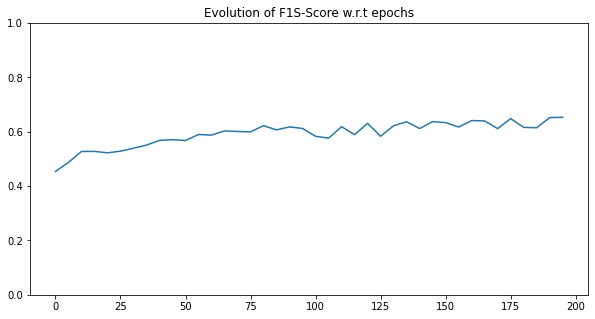

In [ ]:
### F1-SCORE ON TEST DATASET
score_test = evaluate(basic_model, loss_fcn, device, test_dataloader)
print("Basic Model : F1-Score on the test set: {:.4f}".format(score_test))

### PLOT EVOLUTION OF F1-SCORE W.R.T EPOCHS
def plot_f1_score(epoch_list, scores) :
    plt.figure(figsize=[10,5])
    plt.plot(epoch_list, scores)
    plt.title("Evolution of F1S-Score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.show()
    
plot_f1_score(epoch_list, basic_model_scores)

### Define a better model

Now, it's your turn to improve this basic model ! To do so, complete whenever ###### YOUR ANSWER ######## and run the two following cells.

**HINT :** https://arxiv.org/pdf/1710.10903.pdf

In [ ]:
class StudentModel(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, num_layers = 3, num_heads = 2):
          super().__init__()

          self.pipeline = [graphnn.GATv2Conv(in_channels = input_size, out_channels = hidden_size, heads = num_heads)]

          for _ in range(num_layers - 1):
            layer = graphnn.GATv2Conv(in_channels = hidden_size * num_heads, out_channels = hidden_size, heads = num_heads)
            self.pipeline.append(layer)         

          #self.pipeline.append(nn.LeakyReLU(negative_slope = 0.2))
          self.pipeline.append(graphnn.Linear(in_channels = hidden_size * num_heads, out_channels = output_size))
          
          self.pipeline = nn.Sequential(*self.pipeline)


    def forward(self, x, edge_index):

          for layer in self.pipeline[:-2]:
            x = layer(x, edge_index)

          #output = self.pipeline[-2](x)
          output = self.pipeline[-1](x)

          return output

Let's train your model !

In [ ]:
## Student model
student_model = StudentModel(input_size = n_features, 
                                hidden_size = 256, 
                                output_size = n_classes, num_layers = 3, num_heads = 4).to(device)

### DEFINE LOSS FUNCTION AND OPTIMIZER
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.005)

### TRAIN
epoch_list, student_model_scores = train(student_model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader)

Epoch 00001 | Loss: 0.6610
F1-Score: 0.3711
Epoch 00002 | Loss: 0.5516
Epoch 00003 | Loss: 0.5285
Epoch 00004 | Loss: 0.5161
Epoch 00005 | Loss: 0.4933
Epoch 00006 | Loss: 0.4749
F1-Score: 0.5403
Epoch 00007 | Loss: 0.4652
Epoch 00008 | Loss: 0.4393
Epoch 00009 | Loss: 0.4166
Epoch 00010 | Loss: 0.4033
Epoch 00011 | Loss: 0.3921
F1-Score: 0.6685
Epoch 00012 | Loss: 0.3651
Epoch 00013 | Loss: 0.3493
Epoch 00014 | Loss: 0.3757
Epoch 00015 | Loss: 0.3416
Epoch 00016 | Loss: 0.3168
F1-Score: 0.7530
Epoch 00017 | Loss: 0.3032
Epoch 00018 | Loss: 0.2898
Epoch 00019 | Loss: 0.2750
Epoch 00020 | Loss: 0.2688
Epoch 00021 | Loss: 0.2585
F1-Score: 0.7964
Epoch 00022 | Loss: 0.2471
Epoch 00023 | Loss: 0.2366
Epoch 00024 | Loss: 0.2228
Epoch 00025 | Loss: 0.2114
Epoch 00026 | Loss: 0.2049
F1-Score: 0.8410
Epoch 00027 | Loss: 0.2088
Epoch 00028 | Loss: 0.2081
Epoch 00029 | Loss: 0.2017
Epoch 00030 | Loss: 0.1861
Epoch 00031 | Loss: 0.1822
F1-Score: 0.8622
Epoch 00032 | Loss: 0.1727
Epoch 00033 | Los

Let's evaluate the performance of your model

Student Model : F1-Score on the test set: 0.9663


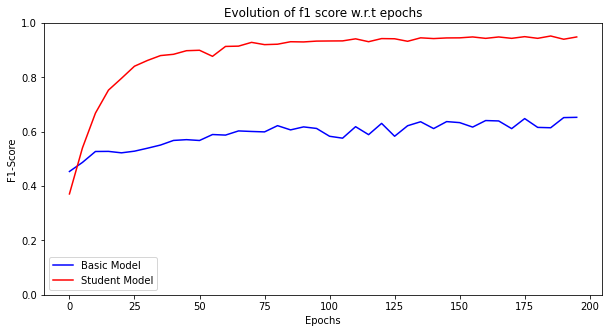

In [ ]:
score_test = evaluate(student_model, loss_fcn, device, test_dataloader)
print("Student Model : F1-Score on the test set: {:.4f}".format(score_test))

def plot_f1_score(epoch_list, basic_model_scores, student_model_scores) :
    plt.figure(figsize = [10,5])
    plt.plot(epoch_list, basic_model_scores, 'b', label = "Basic Model")
    plt.plot(epoch_list, student_model_scores, 'r', label = "Student Model")
    plt.title("Evolution of f1 score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.xlabel("Epochs")
    plt.ylabel("F1-Score")
    plt.legend()
    plt.show()
    
plot_f1_score(epoch_list, basic_model_scores, student_model_scores)

## **PART 2 : QUESTIONS** (12/20)

**1. Make a small paragraph that : (4pts)**
1. Explains your achitecture and justify your choices (why the Graph Layer you chose is more efficient than the GCNLayer from the Basic Model?).
2. Analyses your results (what is the F1-Score ? are your results convincing ? what is your position w.r.t state-of-the-art ?).

**1. Answer :**

1. The model we having the best performances among those we tried to implement is deeply inspired by the GAT algorithm, which is described in the paper given as hint for the exercise. It consists in 3 successive GATv2Layer, which are basically an evolution correcting the static attention problem of the initial GATLayer, the attention layer described in the pre-cited article. Then the results (having the size equals to the multiplication of the hidden_size and num_heads parameters) are sent into a LeakyReLU layer and finally to a Linear layer, which is used for the final categorization of each input in the correct number of categories. We conducted a finetuning of the parameters of this model in order to define : the number of successive GATv2Layers and the number of heads to use as our model can work through the multi-head attention process. We found that the best results were found for a number of successive attention layers equals to 3 and a number of heads equals to 2.  
The use of GATLayers (Attention layers) instead of GraphConv Layers is justified for many reaseons :
  - Contrary to GraphConv Layers, a model with attention layers does not require to have an undirected graph. This is implied by the fact that there is no more an impact of the order of access to the graph. 
  - This model is said to be a lot more efficient, particularly because all steps of it can be parallelized across all edges.
  - Contrary to the GraphConv model, GAT can be used in parallel with the multi-head attention mechanism, which can also increase the efficiency of our model. 

2. We obtained a final F1-Score equals to 0.9784 on the last run (between 0.95 and 0.98 according to the tries). This result is very good, particularly when compared to the Basic Model constructed with GCNLayer whose result is generally not far from 0.6.  
We can compare this result with the state-of-the-art architectures proposed in the previous paper. According to it, the best model (at that time in 2018) was their GAT model (using the basic GATLayer of the torchnn package) with a benchmarked F1-score of 0.973. The model we were able to build is therefore slightly better than the 2018-top-of-the-art models. That can be explained by the similarities between the two models and also by the fact that we are using an upgraded version of the GATLayers
Moreover, after the 200 epochs of the training process, the loss obtained with our model lies between 0.05 and 0.06, which is 10 times less than the initial loss. We see clearly that our model converges to a good solution, and therefore we may say that our results are satisfying.  
Finally, the model we built converges also in a really short time compared to the Basic one. Indeed, after 50 epochs, the F1-score is already above 0.9 in the first case, whereas we can not identify any convergence in the second one, which seems not to have converged even after 200 epochs.

**2. Provide a diagramm of your architecture, which includes a good and clear legend as well as shapes information. The diagramm must be submitted as an external file, along with this notebook (PDF, JEPG or PNG format accepted). (2pts)**

**3. Make a small paragraph that explains: (6pts)**
1. What _oversmoothing_ is in the context of Graph Neural Network. Why is it an issue ? 
2. Are there solutions to overcome it ? 
3. Do you think the model you constructed is robust with respect to oversmoothing ? Why ?

**3. Answer :**

1. Oversmoothing is a phenomenon occuring when information propagation across the graph is too strong, resulting in nodes becoming too similar in their representation. This problem mainly occurs when the network is built with too many layers, each of them being too heavily weighted. As a result, during calculations, all the nodes in the graph will lose their own caracteristics (being "diluted" by all the neighbouring edges) and will therefore become indistinguishable one from one another : this is explaining where the "smoothing" part of the name comes from.
To conclude, oversmoothing often leads to bad (or at least worse) performances, because, with such undistinguability between nodes, the model can not work properly.

2. There are several tehcniques to overcome oversmoothing, among which we can note :
  * Using of dropout can also be used to solve it, because a random drop out of nodes during training will precisely prevent any overfitting and therefore oversmoothing by reducing the number of nodes considered in the neighbourhood of each one. 
  * Using skip connections between layers, which allow for direct information flow between layers and help to prevent the loss of node identity. 
  

3. Our scheme is using the attention principle which is designed to be robust with respect to oversmoothing. Indeed, GAT uses a self-attention mechanism to weight the importance of neighboring nodes, and allows therefore the network to selectively aggregate information from neighbors based on their relevance to the target node, rather than blindly aggregating information from all neighboring nodes, which could have lead to oversmoothing as the nodes of the graph are already well-connected one to each other.  
Finally, as explained before, oversmoothing accurs when too many layers are used in the model. In our case, the architecture of our model consists in only 4 layers (3 GATv2Conv layers and 1 Linear one), and therefore can not be considered as really deep. Therefore, even though we did not used any Dropout (which could once again reduce the risk of oversmoothing), the risk of it remains quite low.